# Betting markets - Monte Carlo simulation of seat outcomes

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Do-the-Monte-Carlo-(MC)-simulation" data-toc-modified-id="Do-the-Monte-Carlo-(MC)-simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do the Monte Carlo (MC) simulation</a></span></li><li><span><a href="#Compile-results-from-MC-simulation" data-toc-modified-id="Compile-results-from-MC-simulation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compile results from MC simulation</a></span></li><li><span><a href="#And-plot-..." data-toc-modified-id="And-plot-...-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>And plot ...</a></span></li></ul></div>

## Python set-up

In [1]:
import datetime

import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import matplotlib.patheffects as pe

import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER, COLOR_GREEN

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter
plt.style.use('./markgraph.mplstyle')

/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Get data

In [2]:
FILE = '../historical-data/sportsbet-2022-individual-seats.csv'
df = pd.read_csv(FILE, na_values = 'SUS', parse_dates=['datetime'])
df = df[df['value'].notna()] # ignore missing values

## Do the Monte Carlo (MC) simulation 

In [3]:
# Key constants ...
IGNORE_ODDS_ABOVE = 20 # dollars - minimise impact of long shot bias
MONTE_CARLO = 500_000 # simulation runs
WIN_THRESH = 75.5 # seats in parliament needed to govern outright

In [4]:
simulations = {}
for seat in df.seat.unique():
    
    # get latest betting market probabilities 
    seat_probs = (
        df[df.seat == seat]
        .pivot(index='datetime', columns='variable', values='value')
        .sort_index(ascending=True)
        .pipe(lambda x: x.iloc[-1]) # last row
        
        # options for managing the favourite-longshot bias (FLB) ...
        # NOTE: change method statement at the end of this statement
        #.pipe(lambda x: x.where(x <= IGNORE_ODDS_ABOVE, other=np.nan)) # trimmed
        #.pipe(lambda x: x * np.sqrt(x)) # x * root(x)
        .pipe(lambda x: x * x) # x squared
        
        .dropna()
        .pipe(lambda x: 1 / x) # convert odds to probabilities
        .pipe(lambda x: x / x.sum()) # standardise so probabilities sum to one
    )
    #flb_method = f'Fav-Longshot bias management: odds > ${IGNORE_ODDS_ABOVE} removed'
    #flb_method = 'Fav-Longshot bias management: odds * sqrt(odds)'
    flb_method = 'Fav-Longshot bias management: odds-squared'
    #flb_method = 'Fav-Longshot bias management: none'
    
    # fix quirky naming by bookmaker
    reindex_map = {
        'Liberal': 'Coalition',
    }
    seat_probs = seat_probs.rename(index=reindex_map)
    
    # simulate election in seat
    simulation = choice(a=seat_probs.index, size=MONTE_CARLO, 
                        p=seat_probs.values)
    simulations[seat] = simulation
results = pd.DataFrame(simulations).T
results.index.name = 'Seat'
results.columns.name = 'Simulation Run'
results.head()

Simulation Run,0,1,2,3,4,5,6,7,8,9,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
Seat,,,,,,,,,,,,,,,,,,,,,
Banks (NSW),Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Labor,Coalition,...,Labor,Coalition,Coalition,Labor,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition
Barton (NSW),Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,...,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor
Bennelong (NSW),Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,...,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition
Berowra (NSW),Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,...,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition
Blaxland (NSW),Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,...,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor


In [5]:
len(results) # Should be 151

151

## Compile results from MC simulation

In [6]:
# count the seats won by party for each simulation run
# this step takes around 25 seconds if MC=100,000 and 2 minutes if MC=500,000
counts = {}
for run in results.columns:
    counts[run] = results[run].value_counts()
counts_df = pd.DataFrame(counts).T.fillna(0.0).astype(int)
counts_df.index.name = 'Simulation Run'
counts_df.columns.name = 'Party'
counts_df.head()

Party,Centre Alliance,Coalition,Green,Independent,Independent 4,Jacqui Lambie Network,Katters Australia Party,Labor,One Nation,United Australia Party
Simulation Run,,,,,,,,,,
0,1,66,4,2,0,0,1,77,0,0
1,1,64,1,5,0,0,1,78,1,0
2,1,68,2,3,0,0,1,76,0,0
3,1,71,1,3,0,0,1,74,0,0
4,1,66,1,5,0,0,1,77,0,0


In [7]:
# Simplified columns (group other parties and independents)
majors = ['Coalition', 'Labor', 'Green']
simplified = counts_df[majors].copy()
simplified['Other'] = (
    counts_df[[x for x in counts_df.columns if x not in majors]]
    .sum(axis=1, skipna=True)
)
simplified.head()

Party,Coalition,Labor,Green,Other
Simulation Run,,,,
0,66,77,4,4
1,64,78,1,8
2,68,76,2,5
3,71,74,1,5
4,66,77,1,7


In [8]:
# hung parliament probability
coalition = ((simplified['Coalition'] > WIN_THRESH).sum() / MONTE_CARLO) * 100 # %
labor = ((simplified['Labor'] > WIN_THRESH).sum() / MONTE_CARLO) * 100 # %
hung = 100 - coalition - labor
parliament = pd.Series([coalition, hung, labor], 
                       index=['Absolute Coalition Majority', 
                              'Hung Parliament', 
                              'Absolute Labor Majority'])
parliament

Absolute Coalition Majority     0.2188
Hung Parliament                41.9934
Absolute Labor Majority        57.7878
dtype: float64

In [9]:
# Count the distribution of seats won by party group, convert to probabilities
freq = {}
for party in simplified.columns:
    freq[party] = simplified[party].value_counts(dropna=True)
win_prob = (pd.DataFrame(freq).fillna(0) / MONTE_CARLO) * 100
win_prob.columns.name = 'Party'
win_prob.index.name = 'Number of Seats Won'
win_prob.head()

Party,Coalition,Labor,Green,Other
Number of Seats Won,,,,
0,0.0,0.0,0.4750,0.0000
1,0.0,0.0,56.5104,0.0002
2,0.0,0.0,32.8972,0.0360
3,0.0,0.0,8.5898,0.8712
4,0.0,0.0,1.3560,7.1714


## And plot ...

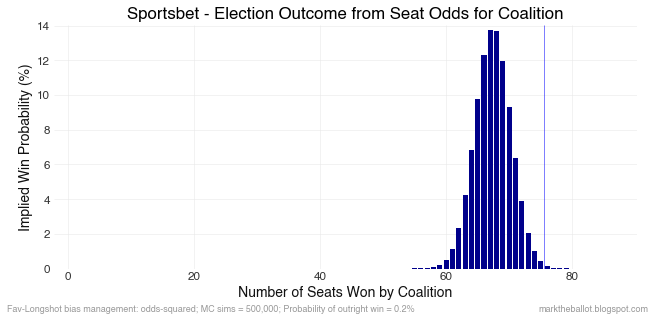

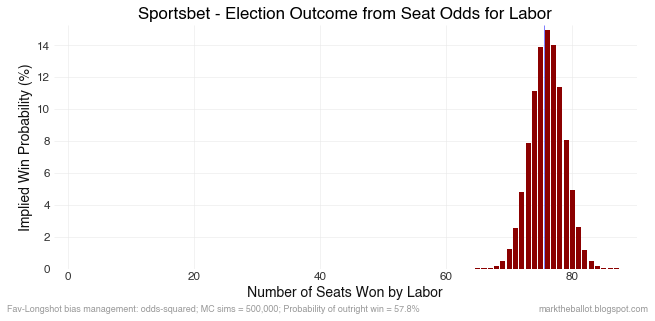

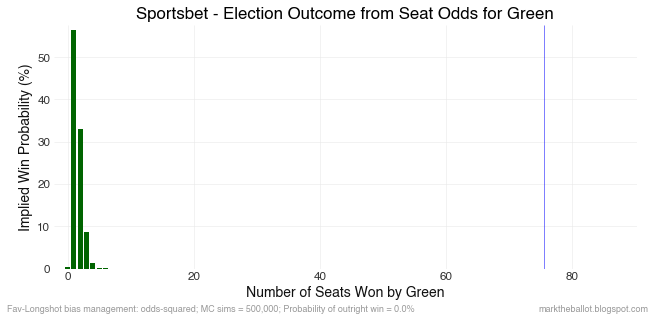

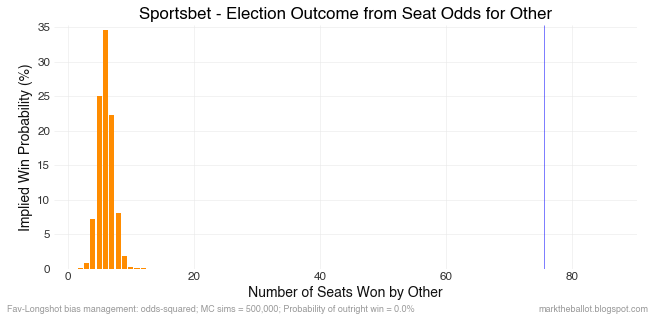

In [10]:
# Plot outcome distributions by party
color_map = {
    'Coalition': COLOR_COALITION, 
    'Labor': COLOR_LABOR, 
    'Other': COLOR_OTHER, 
    'Green': COLOR_GREEN   
}

footer = f'{flb_method}; MC sims = {MONTE_CARLO:,}'

for party in win_prob.columns:
    data = win_prob[party]
    fig, ax = common.initiate_plot()
    ax.bar(data.index, data, color=color_map[party])
    ax.axvline(WIN_THRESH, lw=0.5, c='b')
    title = f'Sportsbet - Election Outcome from Seat Odds for {party}'
    outright = data[data.index > WIN_THRESH].sum()
    lfooter = f'{footer}; Probability of outright win = {outright:.1f}%'
    common.plot_finalise(ax, title=title, ylabel='Implied Win Probability (%)',
                         xlabel=f'Number of Seats Won by {party}',
                         save_suffix=flb_method,
                         lfooter=lfooter)

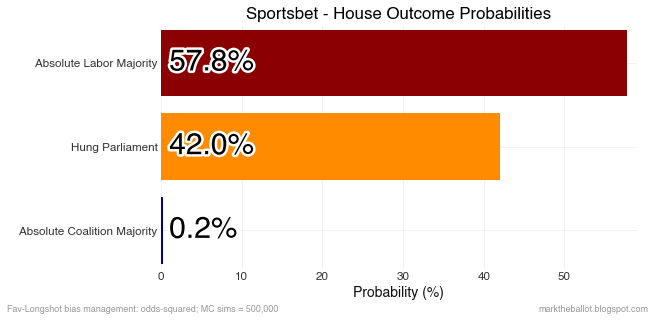

In [11]:
# Plot House Outcome Probabilities
fig, ax = common.initiate_plot()
colors = [COLOR_COALITION, COLOR_OTHER, COLOR_LABOR, ]
ax.barh(parliament.index, parliament, color=colors)
for index, value in parliament.iteritems():
    text = ax.text(x=1, y=index, s=f'{value:.1f}%', 
                   fontsize=30, ha='left', va='center')
    text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])

common.plot_finalise(ax, 'Sportsbet - House Outcome Probabilities',
                     ylabel=None,
                     xlabel='Probability (%)',
                     lfooter=footer,
                     save_suffix=flb_method,
                   )